<a href="https://colab.research.google.com/github/SAH-UJA/Basic-XAI-with-LIME/blob/main/XAI_with_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI with Python's LIME library
In this blog we'll be using LIME to get an explanation as to why a particular prediction is being made. We will train a basic MNIST handwritten digit classification model using Keras and then use LIME.

### What is LIME?
LIME, or Local Interpretable Model-Agnostic Explanations, is an algorithm that can explain the predictions of any classifier or regressor in a faithful way, by approximating it locally with an interpretable model. It modifies a single data sample by tweaking the feature values and observes the resulting impact on the output. It performs the role of an "explainer" to explain predictions from each data sample. The output of LIME is a set of explanations representing the contribution of each feature to a prediction for a single sample, which is a form of local interpretability.

### Building a Digit Classifier
Install tensorflow using the following command on command prompt. Make sure you have **pip** set as environment variable.
```
pip install tensorflow
```
Tensorflow is one the most widely used frameworks for deep learning. Keras has now been included in the tensorflow distribution therefore you need not install it separately. Keras frontend helps reduce lower level training complexity and it a good place to quickly build models. In this case, we have Tensorflow backend with Keras frontend.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

Keras has mnist dataset as a part of its distribution which can be loaded by using *load_data()* method of mnist module. This method returns two tuples representing training and testing data arranged for supervised learning and so we have used x and y representing image and target label respectively. 

Now, the image returned is a 1-D numpy vector of size 784 that is typsecasted from int to float32 and converted to a 2-D matrix of size 28x28. Since the image is grayscale its pixel values range from 0 to 255 therefore we normalize is by dividing by 255.0. This step is an important preprocessing step and large numbers increase training complexity and therefore it is recommended to normalize them between 0 to 1.    

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1,28,28,1)).astype('float32') / 255.0
x_test = x_test.reshape((-1,28,28,1)).astype('float32') / 255.0

Since the lime module that we are using works only with 3-D images, i.e. an image having 3 channels generally RGB, we replicate the grayscale plane here. This code segment converts a grayscale image to RGB by just replicating the available plane. 

In [ ]:
import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb
x_train = to_rgb(x_train)
x_test = to_rgb(x_test)

Sequential API of Keras helps us to quickly create a model but the only drawback is that it is not flexible, i.e. we can have one input and one output unlike the functional API of Keras where we can have multiple inputs and multiple outputs.

This model takes a 3-D image and passes it to a *Conv2D* layers having 16 filters each of size 3x3 and having an activation function of ReLU. Convolution layers basically learns the filter weights and bias and intuitively acts as "eyes" for the model and return feature maps which are then passed to *MaxPooling2D* which by default has a max filter of size 2x2 and it solely reduces the dimension of the feature map from convolutional layer and preserves region of interest to some extent. 

Finally, we flatten the feature map and add a dense layer that should give us a vector of size 10.

In [ ]:
model = keras.Sequential(
    [
     keras.Input(shape=(28,28,3)),
     layers.Conv2D(16, 3, activation='relu'),
     layers.MaxPooling2D(),
     layers.Flatten(),
     layers.Dense(10)
    ]
)

We use *SparseCategoricalCrossentropy(from_logits=True)* since we got a vector of size 10 and we wish to apply a softmax on that to get a one-hot encoded vector. Here, Adam optimizer is used to train the model based on the error in the actual and predicted one-hot vectors. These vector should have one only for the label to which the image belongs.

In [ ]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

The basic CNN model is trained using *model.fit()* for 2 epochs with a batch_size of 32 and a validation set is fed which was segregated earlier while loading the mnist data. 

In [ ]:
model.fit(x_train, y_train, epochs=2, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/2
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4055 - accuracy: 0.8816 - val_loss: 0.0895 - val_accuracy: 0.9731
Epoch 2/2
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0912 - accuracy: 0.9726 - val_loss: 0.0768 - val_accuracy: 0.9748


Our model is trained with a training accuracy of 97% and validation accuracy of 97% which is good enough for this demo. Now, we install LIME module of python using **pip**.

```
pip install lime
```
You can also install modules on jupyter notebook or google colab notebooks using an ! (exclamation symbol) as shown.




In [ ]:
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

*y_train* stores the actual label of each image in the training dataset.

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Now, we find *y_pred_train* which stores the prediction of the model on training image data, *x_train*. The prediction per image is a 1-D vector of 10 numbers and we extract the label by finding the index position of the number with max value. Now, we compare the predicted and actual labels and count the number of bad predictions.

In [ ]:
y_pred_train = model.predict(x_train)
bad_predictions = (y_pred_train.argmax(axis=1) != y_train)
print('Bad predictions:', sum(bad_predictions))

Bad predictions: 1189


Our model is ready and it is time to use LIME for XAI. Using the *lime_image* module of lime package we create an explainer of LimeImageExplainer() class. This object has a method *explain_instance()* which takes 3-d image data and a predictor function, here, model.predict, and based on the predictions by the model's predictor function it returns an explanation. The explanation object has a method *get_image_and_mask()* which takes predicted labels corresponding the 3-d image data earlier parsed and return as (image, mask) tuple, where image is a 3d numpy array and mask is a 2d numpy array that can be used with *skimage.segmentation.mark_boundaries*. The returned image with the corresponding mask represents the features in the image responsible for the prediction.

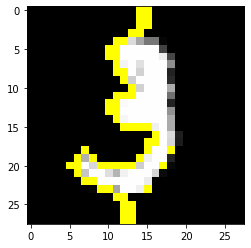

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(x_train[10], model.predict)
plt.imshow(x_train[10])
temp, mask = explanation.get_image_and_mask(model.predict(x_train[10].reshape((1,28,28,3))).argmax(axis=1)[0], positive_only=True, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

With this we come to an end of this blog, I hope it was comprehensive enough. For more info on lime, please refer the [docs](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image). Enjoy and don't forget to like this article if you find this useful and follow me for updates on my future articles.  